## CSC 580 AI II (Winter 2026) **HW\#5 RLHF** -- Start-up code

### **Simple_RLHF.ipynb** -- Simple implementation of Reinforcement Learning Human Feedback (RLHF)

### Students fill in the places indicated with "(*) TODO" (1-15). Sample outputs are baked in this notebook file but also in the html of this file

In [1]:
# ## Code piece to mount my Google Drive
# from google.colab import drive
# drive.mount("/content/drive") # my Google Drive root directory will be mapped here

In [2]:
# # Change the working directory to your own work directory (where the code file is).
# import os
# thisdir = '/content/drive/My Drive/CSC580_Winter2026/hw5_rlhf'
# os.chdir(thisdir)

# # Ensure the files are there (in the folder)
# !pwd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification

/scratch/jshresth/conda/envs/rl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "gpt2"  # https://huggingface.co/openai-community/gpt2
MAX_LENGTH = 256
BATCH_SIZE = 8

print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # load from HuggingFace
tokenizer.pad_token = tokenizer.eos_token

Device: cuda
Model: gpt2


## Part 1: Supervised Fine-Tuning (SFT) of Policy Model

We use [databricks-dolly-15k](https://huggingface.co/datasets/databricks/databricks-dolly-15k) -- "an open source dataset of instruction-following records generated by thousands of Databricks employees in several of the behavioral categories outlined in the InstructGPT paper".




In [5]:
# %%
class SFTDataset:
    def __init__(self, sample_size=10000):
        print("Loading SFT dataset...")
        # Use a reasonable-sized instruction dataset
        dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

        # Limit to sample_size
        sample_size = min(sample_size, len(dataset))
        dataset = dataset.select(range(sample_size))

        # Format for instruction following
        def format_example(example):
            return {
                'text': f"Instruction: {example['instruction']}\nContext: {example['context']}\nResponse: {example['response']}"
            }

        self.dataset = dataset.map(format_example, remove_columns=['instruction', 'context', 'response', 'category'])
        print(f"SFT dataset size: {len(self.dataset)}")

    def get_batch(self, batch_size=BATCH_SIZE):
        """Get batch for SFT training (by random sampling)"""
        indices = np.random.choice(len(self.dataset), batch_size, replace=False)
        texts = [self.dataset[int(i)]['text'] for i in indices]

        # Tokenize
        tokens = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )

        return tokens

In [6]:
# Function for sft training
def train_sft(num_steps=200):
    """Simple SFT training"""
    print("\n" + "="*50)
    print("STEP 1: SUPERVISED FINE-TUNING")
    print("="*50)

    # Load model -- CausalLM model (thus language modelling)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    model = model.to(device)

    # Ensure pad token is set for SFT model config
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    # Dataset
    dataset = SFTDataset(sample_size=5000)

    # Create an optimizer for the model
    # Use AdamW Optimizer with learning rate 2e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # Training loop
    model.train()
    losses = []

    for step in range(num_steps):
        batch = dataset.get_batch(batch_size=BATCH_SIZE)
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass -- pass inputs and labels
        outputs = model(**batch, labels=batch['input_ids'])
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Keep track of the losses
        losses.append(loss.item())

        if step % 50 == 0:
            print(f"  Step {step}/{num_steps}: Loss={loss.item():.4f}")

    print("SFT training complete!")

    # Save the model
    model.save_pretrained("./sft_model")
    tokenizer.save_pretrained("./sft_model")

    return model

#----------------------------
# Skip retraining — load the existing 200-step SFT checkpoint.
# (Retraining is skipped here; Part 1 outputs are already documented.)
# train_sft() is defined above for reference and for Experiment C's continuation.
import os
if os.path.exists("./sft_model"):
    print("\nLoading existing SFT checkpoint from ./sft_model ...")
    sft_model = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)
    if sft_model.config.pad_token_id is None:
        sft_model.config.pad_token_id = tokenizer.pad_token_id
    print("SFT model loaded. (Trained for 200 steps; final loss = 1.3132)")
else:
    print("./sft_model not found — running train_sft() ...")
    sft_model = train_sft()


Loading existing SFT checkpoint from ./sft_model ...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 676.01it/s, Materializing param=transformer.wte.weight]             


SFT model loaded. (Trained for 200 steps; final loss = 1.3132)


## Part 2: Preference Dataset for Reward Modeling

We use [Anthropic/hh-rlhf](https://huggingface.co/datasets/Anthropic/hh-rlhf) -- a dataset containing "Human preference data about helpfulness and harmlessness".  It has columns "chosen" and "rejected".

For training, the default size of 8_000 instances, randomly chosen, are used.

In [7]:
# %%
class PreferenceDataset:
    def __init__(self, sample_size=10000):
        print("\nLoading preference dataset...")
        # Use Anthropic HH-RLHF dataset
        dataset = load_dataset("Anthropic/hh-rlhf", split="train")

        # Limit to sample_size
        sample_size = min(sample_size, len(dataset))
        dataset = dataset.select(range(sample_size))

        # Process examples
        processed_data = []
        for example in dataset:
            chosen = example['chosen']
            rejected = example['rejected']

            # Extract assistant responses (last part after "Assistant: ")
            # The format is: [human message]\n\nAssistant: [response]
            if "\n\nAssistant: " in chosen:
                chosen_response = chosen.split("\n\nAssistant: ")[-1] # Get the response part
                rejected_response = rejected.split("\n\nAssistant: ")[-1] # Same for rejected

                # Extract prompt (everything before assistant response)
                prompt = chosen.split("\n\nAssistant: ")[0]  # Get the prompt part


                if len(chosen_response) > 10 and len(rejected_response) > 10:
                    processed_data.append({
                        'prompt': prompt,
                        'chosen': chosen_response,
                        'rejected': rejected_response
                    })

        self.data = processed_data
        print(f"Preference dataset size: {len(self.data)}")

    def get_batch(self, batch_size=BATCH_SIZE):
        """Get batch of (prompt, chosen, rejected)"""
        indices = np.random.choice(len(self.data), batch_size, replace=False)
        batch = [self.data[int(i)] for i in indices]

        # Tokenize
        prompts = [item['prompt'] for item in batch]
        chosen_texts = [item['chosen'] for item in batch]
        rejected_texts = [item['rejected'] for item in batch]

        # Tokenize prompts
        prompt_tokens = tokenizer(
            prompts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH // 2,
            return_tensors="pt"
        )

        # Tokenize responses
        chosen_tokens = tokenizer(
            chosen_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH // 2,
            return_tensors="pt"
        )

        rejected_tokens = tokenizer(
            rejected_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH // 2,
            return_tensors="pt"
        )

        return prompt_tokens, chosen_tokens, rejected_tokens

#-------------------------------------------
# Create dataset
pref_dataset = PreferenceDataset(sample_size=8000)


Loading preference dataset...
Preference dataset size: 7731


## Part 3: Reward Model Training

Note that input text is first tokenized by the tokenizer, and a tensor of the token ids is created.  The remaining positions after the fixed length of tensor will be filled with pad_tokens, and an attention mask is created based on that (entry values 1 for in-sentences, 0 for padding).

For each instance, the reward model processes a pair: a chosen text and a rejected text.  Each one produces a reward score.  We examine the difference between the two scores then... (you figure out the rest).

For **training**, the poor model uses 30% of the randomly selected instances, while the good model uses 100% of the instances.

For **evaluation**, 30 instances for the poor model and 100 instances for the good models, both randomly chosen, are used.

In [8]:
# %%
class RewardModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Start from the pretrained model from HuggingFace (with classification head)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=1
        )

        # Ensure pad token is set
        if self.model.config.pad_token_id is None:
            self.model.config.pad_token_id = tokenizer.pad_token_id

    def forward(self, input_ids, attention_mask):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).logits.squeeze(-1)

    def compute_loss(self, chosen, rejected):
        chosen_rewards = self.forward(chosen['input_ids'], chosen['attention_mask'])
        rejected_rewards = self.forward(rejected['input_ids'], rejected['attention_mask'])

        # Implement the Bradley-Terry loss
        # The loss should encourage chosen_rewards > rejected_rewards
        # Use log sigmoid of the difference
        diff = chosen_rewards - rejected_rewards

        # Compute the Bradley-Terry loss
        loss = -F.logsigmoid(diff).mean() # mean over minibatch

        # accuracy is when diff is > 0 (and the mean over the list)
        accuracy = (diff > 0).float().mean()

        return loss, accuracy

#--------------------
def train_reward_model(train_fraction=1.0, name="Model"):
    """Train reward model with different quality levels"""
    model = RewardModel().to(device)

    # Create an optimizer for the reward model
    # Use Adam with learning rate 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    print(f"\nTraining {name} reward model...")

    model.train()
    steps = int(100 * train_fraction)  # Adjust fraction based on desired quality

    # training using instances randomly chosen from preference data
    for step in range(steps):
        _, chosen, rejected = pref_dataset.get_batch(batch_size=BATCH_SIZE)

        # Move to device
        chosen = {k: v.to(device) for k, v in chosen.items()}
        rejected = {k: v.to(device) for k, v in rejected.items()}

        # Compute the loss using the reward model's compute_loss method 
        loss, accuracy = model.compute_loss(chosen, rejected)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"  Step {step}/{steps}: Loss={loss.item():.4f}")

    print("Reward model training complete!")
    model.eval()
    return model

#--------------------
print("\n" + "="*50)
print("STEP 2: REWARD MODEL TRAINING")
print("="*50)

#-----------------------------------------------
# Train two reward models with different quality
#-----------------------------------------------
poor_rm = train_reward_model(train_fraction=0.3, name="POOR")
good_rm = train_reward_model(train_fraction=1.0, name="GOOD")


STEP 2: REWARD MODEL TRAINING


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 557.44it/s, Materializing param=transformer.wte.weight]             
GPT2ForSequenceClassification LOAD REPORT from: gpt2
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Training POOR reward model...
  Step 0/30: Loss=0.8299
  Step 20/30: Loss=1.1349
Reward model training complete!


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 606.84it/s, Materializing param=transformer.wte.weight]             
GPT2ForSequenceClassification LOAD REPORT from: gpt2
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Training GOOD reward model...
  Step 0/100: Loss=0.6323
  Step 20/100: Loss=0.9834
  Step 40/100: Loss=0.8779
  Step 60/100: Loss=0.7275
  Step 80/100: Loss=0.7998
Reward model training complete!


## 3.1 Evaluate reward models

Evaluate each reward model using randomly selected from the preference data.

In [9]:
def evaluate_rm(model, num_batches=20):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for _ in range(num_batches):
            _, chosen, rejected = pref_dataset.get_batch(batch_size=8)

            chosen = {k: v.to(device) for k, v in chosen.items()}
            rejected = {k: v.to(device) for k, v in rejected.items()}

            chosen_rewards = model(chosen['input_ids'], chosen['attention_mask'])
            rejected_rewards = model(rejected['input_ids'], rejected['attention_mask'])

            # Count how many times chosen_rewards > rejected_rewards
            # This is the accuracy metric
            correct = (chosen_rewards > rejected_rewards).sum().item()

            total_correct += correct
            total_samples += len(chosen_rewards)

    return total_correct / total_samples

poor_acc = evaluate_rm(poor_rm)
good_acc = evaluate_rm(good_rm)

print(f"\nReward Model Evaluation:")
print(f"  Poor RM Accuracy: {poor_acc:.4f}")
print(f"  Good RM Accuracy: {good_acc:.4f}")


Reward Model Evaluation:
  Poor RM Accuracy: 0.4875
  Good RM Accuracy: 0.5500


## Part 4: PPO Implementation

Policy model starts with the model that resulted from the supervised fine-tuned (SFT) earlier in Part 1. The algorithm also utilizes a model (another one) as a (frozen) **reference model** to compute KL divergence.

In [10]:
# %%
class SimplePPO:
    def __init__(self, reward_model):
        # Start from the Policy model fine-tuned earlier (saved in a subfolder)
        self.policy = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)
        self.reward_model = reward_model
        # reference model as the base model
        self.ref_model = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)

        # Ensure pad token is set for policy and ref_model configs
        if self.policy.config.pad_token_id is None:
            self.policy.config.pad_token_id = tokenizer.pad_token_id
        if self.ref_model.config.pad_token_id is None:
            self.ref_model.config.pad_token_id = tokenizer.pad_token_id

        # Freeze the reference model parameters
        for param in self.ref_model.parameters():
            param.requires_grad = False

        # Create an optimizer for the policy model
        # Use Adam with learning rate 5e-6
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=5e-6)

        self.rewards_history = []
        self.kl_history = []
        self.episode_rewards = []  # For tracking per-episode rewards
        self.episode_kls = []      # For tracking per-episode KL divergences

    def generate_response(self, prompt, max_tokens=64):
        """Generate response with log probabilities"""
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        # Present the (tokenized) input to the model
        with torch.no_grad():
            outputs = self.policy.generate(
                **inputs,
                max_new_tokens=max_tokens,
                do_sample=True,
                temperature=0.8,
                top_k=40,
                top_p=0.9,
                return_dict_in_generate=True,
                output_scores=True,
                pad_token_id=tokenizer.pad_token_id # Explicitly set pad_token_id
            )

        # Token ids of the generated response text
        response_ids = outputs.sequences

        # Get log probabilities
        if outputs.scores:
            logits = outputs.scores[-1]  # output from the last token only (simplified)
            log_probs = F.log_softmax(logits, dim=-1) # log-softmax'ed
        else:
            log_probs = None

        return response_ids, log_probs

    def compute_reward(self, response_ids):
        """Get reward from reward model"""
        attention_mask = torch.ones_like(response_ids)
        # reward score as the mean of the tokens in the response
        reward = self.reward_model(response_ids, attention_mask).mean()
        return reward

    def compute_kl(self, response_ids):
        """Compute KL divergence between policy and reference models"""
        attention_mask = torch.ones_like(response_ids)

        with torch.no_grad():
            # Get the logits from the reference model
            ref_outputs = self.ref_model(input_ids=response_ids, attention_mask=attention_mask, use_cache=False, return_dict=True)
            ref_logits = ref_outputs.logits

        # Get the logits from the policy model
        policy_outputs = self.policy(input_ids=response_ids, attention_mask=attention_mask, use_cache=False, return_dict=True)
        policy_logits = policy_outputs.logits

        # KL calculation
        kl = F.kl_div(
            F.log_softmax(policy_logits[:, :-1], dim=-1),
            F.softmax(ref_logits[:, :-1], dim=-1),
            reduction='batchmean'
        )

        return kl

    def train_step(self, prompt, kl_weight=0.01):
        """Single PPO step"""
        self.policy.train()

        # Generate response (from the policy model)
        response_ids, _ = self.generate_response(prompt)

        # Compute reward
        reward = self.compute_reward(response_ids)

        # Compute KL penalty
        kl_penalty = self.compute_kl(response_ids)

        # Compute the PPO loss
        # We want to maximize reward but minimize KL divergence
        loss = -1.0 * reward + kl_weight * kl_penalty

        # Clip the loss of gradients
        # torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)

        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.optimizer.step()

        return reward.item(), kl_penalty.item()

    def train(self, prompts, num_episodes=80):
        """Training loop.  NOTE: Ooutput texts are evaluated by the GOOD reward model."""
        print(f"\nTraining PPO with {'POOR' if self.reward_model == poor_rm else 'GOOD'} reward model...")

        # Clear history
        self.rewards_history = []
        self.kl_history = []
        self.episode_rewards = []
        self.episode_kls = []

        for episode in range(num_episodes):
            # Sample multiple prompts per episode for better training
            num_prompts_per_episode = 3  # Multiple prompts per episode
            batch_rewards = []
            batch_kls = []

            for _ in range(num_prompts_per_episode):
                # Select a prompt (tried in this episode)
                if episode < len(prompts):
                    # Early: go through prompts systematically
                    prompt_idx = episode % len(prompts)
                    prompt = prompts[prompt_idx]
                else:
                    # Later: random sampling
                    prompt = np.random.choice(prompts)

                # Reward and KL divergence score from this prompt
                reward, kl = self.train_step(prompt)
                batch_rewards.append(reward)
                batch_kls.append(kl)

            # Average over batch
            avg_reward = np.mean(batch_rewards)
            avg_kl = np.mean(batch_kls)

            # Track metrics
            self.episode_rewards.append(avg_reward)
            self.episode_kls.append(avg_kl)
            self.rewards_history.append(avg_reward)
            self.kl_history.append(avg_kl)

            # Logging -- Compute the average reward over the last 20 episodes
            if (episode + 1) % 20 == 0:
                # Compute moving averages
                recent_rewards = self.episode_rewards[-20:] if len(self.episode_rewards) >= 20 else self.episode_rewards
                recent_kls = self.episode_kls[-20:] if len(self.episode_kls) >= 20 else self.episode_kls

                avg_recent_reward = np.mean(recent_rewards)
                avg_recent_kl = np.mean(recent_kls)

                print(f"  Episode {episode+1}/{num_episodes}: "
                      f"Reward={avg_reward:.4f} (Avg20={avg_recent_reward:.4f}), "
                      f"KL={avg_kl:.4f} (Avg20={avg_recent_kl:.4f})")

        return self.episode_rewards, self.episode_kls


## Part 5: Training Prompts

In [11]:
# Load training prompts
import ppo_train_prompts
from ppo_train_prompts import training_prompts

print(f"Number of training prompts: {len(training_prompts)}")

Number of training prompts: 624


## Part 6: Train PPO with Both Reward Models

In [12]:
# %%
print("\n" + "="*60)
print("STEP 3: PPO TRAINING (with enhanced prompts)")
print("="*60)

# Use augmented prompts for training
ppo_training_prompts = training_prompts

print("\n1. Training with POOR reward model...")
ppo_poor = SimplePPO(poor_rm)
poor_rewards, poor_kls = ppo_poor.train(ppo_training_prompts, num_episodes=150)

print("\n2. Training with GOOD reward model...")
ppo_good = SimplePPO(good_rm)
good_rewards, good_kls = ppo_good.train(ppo_training_prompts, num_episodes=150)


STEP 3: PPO TRAINING (with enhanced prompts)

1. Training with POOR reward model...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 563.47it/s, Materializing param=transformer.wte.weight]             



Training PPO with POOR reward model...
  Episode 20/150: Reward=-2.3754 (Avg20=-4.0542), KL=9.1309 (Avg20=12.9498)
  Episode 40/150: Reward=-4.5556 (Avg20=-3.9264), KL=9.6118 (Avg20=10.4008)
  Episode 60/150: Reward=-4.4727 (Avg20=-3.7110), KL=9.9106 (Avg20=10.3415)
  Episode 80/150: Reward=-3.9395 (Avg20=-3.8296), KL=14.5511 (Avg20=10.0923)
  Episode 100/150: Reward=-4.0851 (Avg20=-4.1845), KL=9.0501 (Avg20=10.6264)
  Episode 120/150: Reward=-3.8173 (Avg20=-3.7401), KL=10.3543 (Avg20=8.9671)
  Episode 140/150: Reward=-4.1657 (Avg20=-4.0186), KL=8.4834 (Avg20=9.4174)

2. Training with GOOD reward model...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 583.03it/s, Materializing param=transformer.wte.weight]             



Training PPO with GOOD reward model...
  Episode 20/150: Reward=12.1297 (Avg20=7.5757), KL=11.0592 (Avg20=12.8924)
  Episode 40/150: Reward=8.8728 (Avg20=6.8931), KL=7.4938 (Avg20=10.1741)
  Episode 60/150: Reward=8.0924 (Avg20=6.9225), KL=10.5389 (Avg20=10.5752)
  Episode 80/150: Reward=5.7370 (Avg20=6.5387), KL=6.2374 (Avg20=9.7529)
  Episode 100/150: Reward=6.6223 (Avg20=6.5116), KL=10.8853 (Avg20=10.3752)
  Episode 120/150: Reward=5.5096 (Avg20=7.6477), KL=6.8371 (Avg20=9.0678)
  Episode 140/150: Reward=5.7344 (Avg20=7.3802), KL=9.5493 (Avg20=9.8334)


## Part 7: Evaluation and Comparison

Evaluate the two policy models (using poor/good reward models) plus Base and SFT models, using the unseen evaluation prompts.

In [13]:
from ppo_train_prompts import evaluation_prompts

def evaluate_policy(policy, reward_model, eval_prompts):
    """Evaluate policy using reward model"""
    policy.eval()
    rewards = []
    all_responses = []

    with torch.no_grad():
        for prompt in eval_prompts:
            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            output = policy.generate(
                **inputs,
                max_new_tokens=128,
                do_sample=True,
                temperature=0.7,
                pad_token_id=tokenizer.pad_token_id # Explicitly set pad_token_id to suppress warning
            )

            reward = reward_model(output, torch.ones_like(output)).mean().item()
            rewards.append(reward)

            # Store response for first few prompts
            if len(all_responses) < 5:
                response = tokenizer.decode(output[0], skip_special_tokens=True)
                response = response[len(prompt):].strip()
                all_responses.append({
                    'prompt': prompt[:50] + "..." if len(prompt) > 50 else prompt,
                    'response': response[:100] + "..." if len(response) > 100 else response,
                    'reward': reward
                })

    policy.train()
    return {
        'mean': np.mean(rewards),
        'std': np.std(rewards),
        'min': np.min(rewards),
        'max': np.max(rewards),
        'median': np.median(rewards),
        'all_rewards': rewards,
        'sample_responses': all_responses
    }

#-------------------------------
print("\n" + "="*70)
print("FINAL EVALUATION ON ALL 200+ EVALUATION PROMPTS")
print("="*70)

## Load (and specify) four models for comparison
# 1. Base model -- an off-the-chelf LM (distilgpt2)
base_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)
# Ensure pad_token_id is set for base_model config
if base_model.config.pad_token_id is None:
    base_model.config.pad_token_id = tokenizer.pad_token_id

# 2. SFT model -- after fine-tuning the base model (Part 1)
sft_model_eval = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)
# Ensure pad_token_id is set for sft_model_eval config
if sft_model_eval.config.pad_token_id is None:
    sft_model_eval.config.pad_token_id = tokenizer.pad_token_id

# 3. and 4. are from the cell above (ppo_poor.policy and ppo_good.policy)

# Evaluate all models using GOOD reward model using GOOD RM as judge (to give eval scores)
print("\nEvaluating models (using GOOD RM as judge):")

# Evaluation
base_results = evaluate_policy(base_model, good_rm, evaluation_prompts)
sft_results = evaluate_policy(sft_model_eval, good_rm, evaluation_prompts)
poor_results = evaluate_policy(ppo_poor.policy, good_rm, evaluation_prompts)
good_results = evaluate_policy(ppo_good.policy, good_rm, evaluation_prompts)

# Print comprehensive evaluation results
print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*70)
print(f"\n{'Model':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Median':<10}")
print("-" * 70)
print(f"{'Base Model':<20} {base_results['mean']:.4f}    {base_results['std']:.4f}    {base_results['min']:.4f}    {base_results['max']:.4f}    {base_results['median']:.4f}")
print(f"{'SFT Model':<20} {sft_results['mean']:.4f}    {sft_results['std']:.4f}    {sft_results['min']:.4f}    {sft_results['max']:.4f}    {sft_results['median']:.4f}")
print(f"{'Poor RM Policy':<20} {poor_results['mean']:.4f}    {poor_results['std']:.4f}    {poor_results['min']:.4f}    {poor_results['max']:.4f}    {poor_results['median']:.4f}")
print(f"{'Good RM Policy':<20} {good_results['mean']:.4f}    {good_results['std']:.4f}    {good_results['min']:.4f}    {good_results['max']:.4f}    {good_results['median']:.4f}")

# Calculate percentage improvement over base model on evaluation set
print(f"\nIMPROVEMENT OVER BASE MODEL (on evaluation set):")
base_mean = base_results['mean']
sft_improvement = ((sft_results['mean'] - base_mean) / abs(base_mean)) * 100
poor_improvement = ((poor_results['mean'] - base_mean) / abs(base_mean)) * 100
good_improvement = ((good_results['mean'] - base_mean) / abs(base_mean)) * 100

print(f"  SFT Model:      {sft_improvement:+.2f}%")
print(f"  Poor RM Policy: {poor_improvement:+.2f}%")
print(f"  Good RM Policy: {good_improvement:+.2f}%")

# Show sample responses from evaluation (5 instances in each result)
print("\n" + "="*70)
print("SAMPLE RESPONSES FROM EVALUATION PROMPTS")
print("="*70)
print("\nBase Model - Sample Responses:")
for i, sample in enumerate(base_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")

print("\nSFT Model - Sample Responses:")
for i, sample in enumerate(sft_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")

print("\nPoor RM Policy - Sample Responses:")
for i, sample in enumerate(poor_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")

print("\nGood RM Policy - Sample Responses:")
for i, sample in enumerate(good_results['sample_responses'], 1):
    print(f"  {i}. Prompt: {sample['prompt']}")
    print(f"     Response: {sample['response']}")
    print(f"     Reward: {sample['reward']:.4f}\n")


FINAL EVALUATION ON ALL 200+ EVALUATION PROMPTS


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 501.59it/s, Materializing param=transformer.wte.weight]             



Evaluating models (using GOOD RM as judge):

COMPREHENSIVE EVALUATION RESULTS

Model                Mean       Std        Min        Max        Median    
----------------------------------------------------------------------
Base Model           6.1745    6.5392    -11.5111    17.7827    7.7205
SFT Model            6.0440    4.7573    -13.4828    18.0040    6.7359
Poor RM Policy       5.6269    6.2771    -11.2729    17.8749    6.5434
Good RM Policy       6.6267    5.2561    -10.0086    17.8165    6.7890

IMPROVEMENT OVER BASE MODEL (on evaluation set):
  SFT Model:      -2.11%
  Poor RM Policy: -8.87%
  Good RM Policy: +7.32%

SAMPLE RESPONSES FROM EVALUATION PROMPTS

Base Model - Sample Responses:
  1. Prompt: Explain how a CPU processes instructions:
     Response: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...
     Reward: 12.7161

  2. Prompt: What is the difference between HTTP and HTTPS?
     Response: HTTP is the univers

## Part 8: Visualization

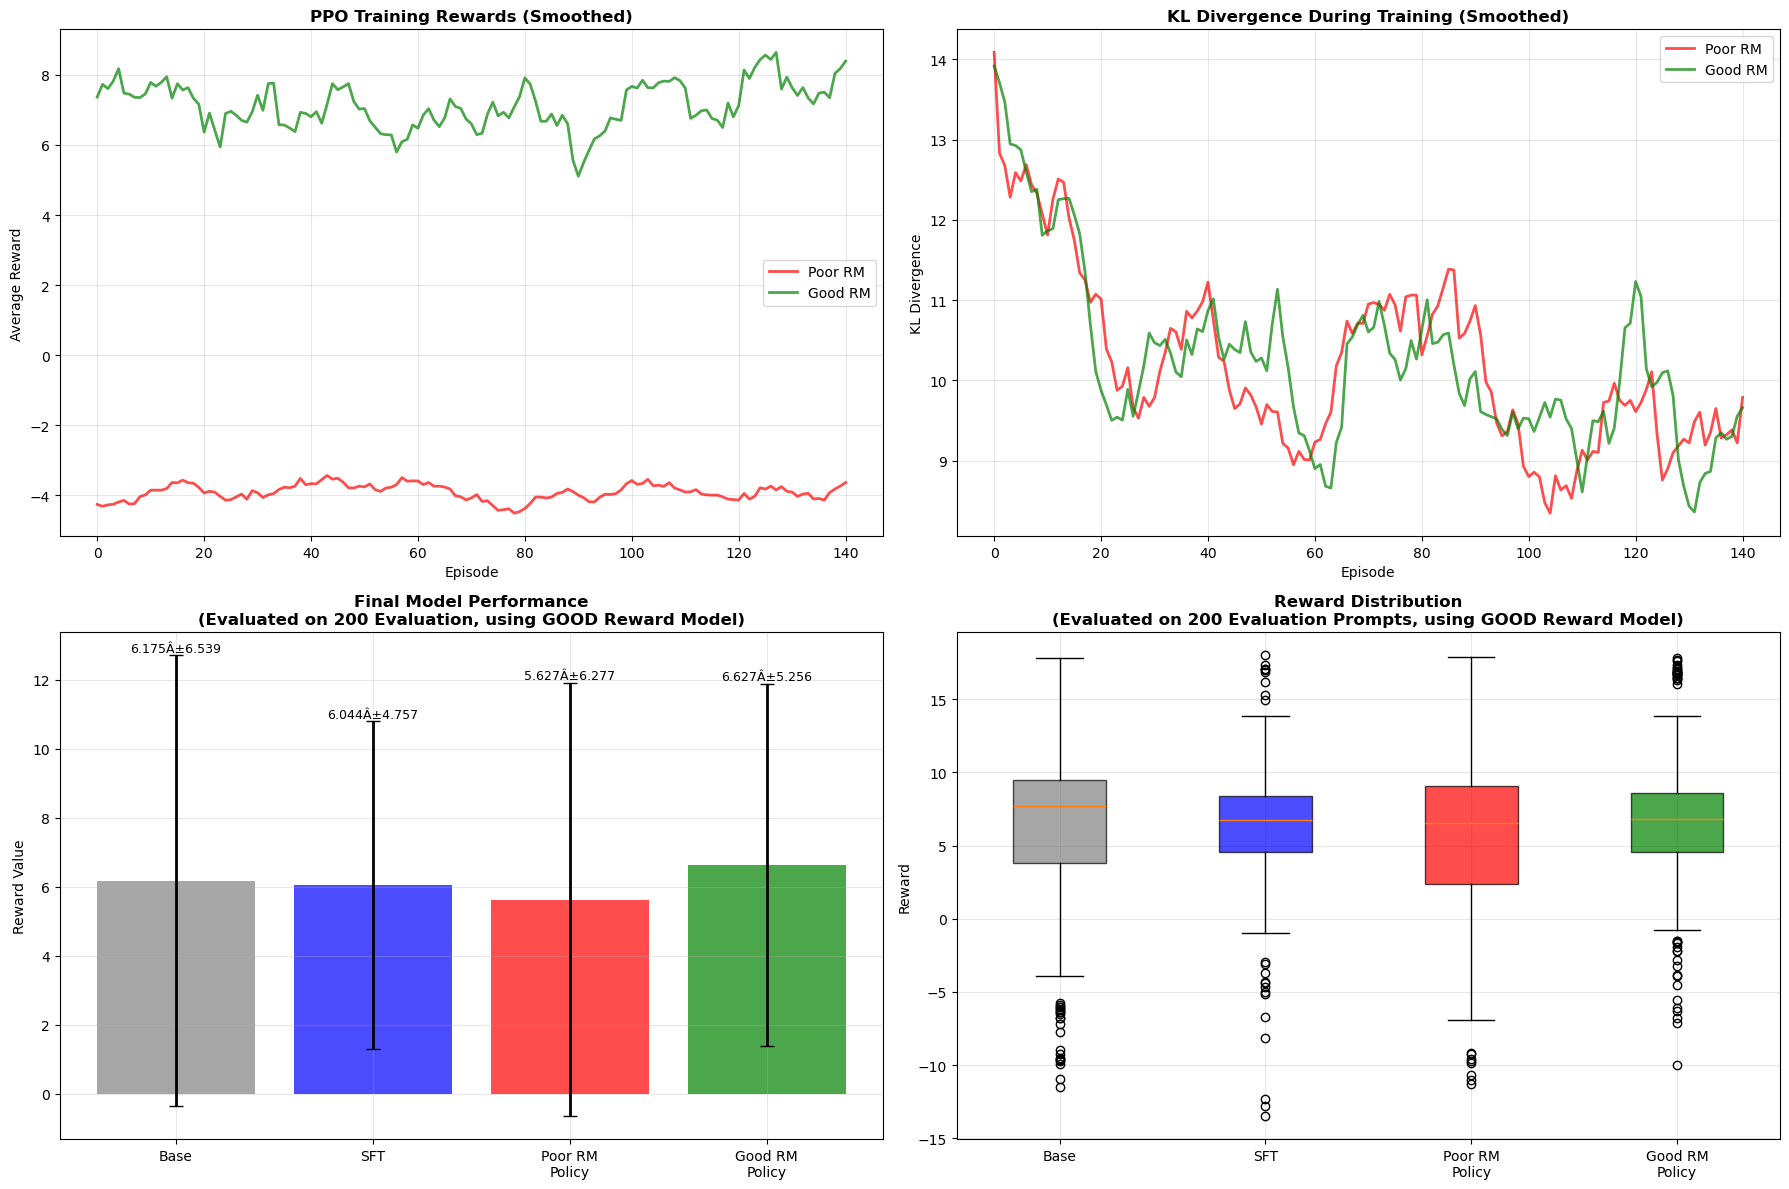

In [14]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # Changed to 2x2 grid

# 1. Training rewards comparison (with smoothing)
window = 10
def smooth(data, window_size=window):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

if len(poor_rewards) > window:
    smooth_poor = smooth(poor_rewards)
    smooth_good = smooth(good_rewards)

    axes[0, 0].plot(smooth_poor, label='Poor RM', color='red', alpha=0.7, linewidth=2)
    axes[0, 0].plot(smooth_good, label='Good RM', color='green', alpha=0.7, linewidth=2)
    axes[0, 0].set_title('PPO Training Rewards (Smoothed)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Average Reward')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. KL divergence during training
if len(poor_kls) > window:
    smooth_poor_kl = smooth(poor_kls)
    smooth_good_kl = smooth(good_kls)

    axes[0, 1].plot(smooth_poor_kl, label='Poor RM', color='red', alpha=0.7, linewidth=2)
    axes[0, 1].plot(smooth_good_kl, label='Good RM', color='green', alpha=0.7, linewidth=2)
    axes[0, 1].set_title('KL Divergence During Training (Smoothed)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('KL Divergence')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Final performance comparison on FULL EVALUATION SET (now axes[1,0])
final_scores = [base_results['mean'], sft_results['mean'], poor_results['mean'], good_results['mean']]
score_stds = [base_results['std'], sft_results['std'], poor_results['std'], good_results['std']]
labels = ['Base', 'SFT', 'Poor RM\nPolicy', 'Good RM\nPolicy']
colors = ['gray', 'blue', 'red', 'green']

x_pos = np.arange(len(labels))
bars = axes[1, 0].bar(x_pos, final_scores, yerr=score_stds,
                      color=colors, alpha=0.7, capsize=5, error_kw={'elinewidth': 2})
axes[1, 0].set_title(f'Final Model Performance\n(Evaluated on {len(evaluation_prompts)} Evaluation, using GOOD Reward Model)',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Reward')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 0].set_ylabel('Reward Value') # Kept this as it clarifies the y-axis for the bar chart.
axes[1, 0].grid(True, alpha=0.3)

# Add mean and std annotations
for i, (bar, score, std) in enumerate(zip(bars, final_scores, score_stds)):
    height = bar.get_height()
    axes[1, 0].text(i, height + std + 0.02, f'{score:.3f}\u00c2\u00b1{std:.3f}',
                    ha='center', va='bottom', fontsize=9)

# 4. Reward distribution boxplot (now axes[1,1])
all_rewards = [
    base_results['all_rewards'],
    sft_results['all_rewards'],
    poor_results['all_rewards'],
    good_results['all_rewards']
]
bp = axes[1, 1].boxplot(all_rewards, tick_labels=labels, patch_artist=True)
colors_box = ['gray', 'blue', 'red', 'green']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_title(f'Reward Distribution\n(Evaluated on {len(evaluation_prompts)} Evaluation Prompts, using GOOD Reward Model)',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Reward')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **(*) TODO 15**
## Part 9: Evaluation using the HELD-OUT test prompts

Make up three (3) additional prompts by yourself.  Present each one to all four models (base, sft, poorRM, goodRM) and show the outputs.

In [15]:
test_prompts = [
    "What are the benefits of regular exercise?",
    "Describe how computers store information",
    "Explain longevity:",
]

def generate_and_display(prompt, model, model_name, max_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id
        )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    response = response[len(prompt):].strip()
    print(f"  [{model_name}]: {response[:200]}")

models = {
    "Base Model": base_model,
    "SFT Model": sft_model_eval,
    "Poor RM Policy": ppo_poor.policy,
    "Good RM Policy": ppo_good.policy,
}

for prompt in test_prompts:
    print(f"\nPrompt: \"{prompt}\"")
    print("-" * 60)
    for name, model in models.items():
        model.eval()
        generate_and_display(prompt, model, name)


Prompt: "What are the benefits of regular exercise?"
------------------------------------------------------------
  [Base Model]: The benefits of regular exercise (for a full list of benefits, see Exercise & Physical Activity Benefits of Regular Exercise) include:

• You're less likely to suffer from cardiovascular disease

• Yo
  [SFT Model]: Context: Regular exercise is an important part of healthy living. It helps reduce stress, relieve stress, and improve muscle strength. It also helps prevent disease and prevent premature aging (includ
  [Poor RM Policy]: Context: Exercise improves many different physical and cognitive functions. It increases blood flow to your muscles, improves blood oxygen levels, and improves concentration. In addition, exercise imp
  [Good RM Policy]: What are the risks of exercise? What are the risks of strenuous activities?
Exercise: Regular exercise is the primary activity of the body and allows for a higher level of energy expenditure. It allow

Prompt: "

---
## Part 2: Improvement Experiments (Task 3)

I tested three changes to improve output quality:
- A) decoding settings
- B) prompt format (instruction vs continuation + few-shot)
- C) more SFT training (200 vs 500 vs 1000)

For each one, I show the code change, the results, and a short explanation.


### Experiment A: Better Generation Parameters (Option 1)

I updated `generate_response` to support different decoding settings and compared multiple configs on the same held-out prompts.

In [16]:
print("=" * 60)
print("EXPERIMENT A: Better Generation Parameters")
print("=" * 60)

# 1) Modify generate_response to support configurable decoding params.
def _generate_response_v2(
    self,
    prompt,
    max_tokens=64,
    temperature=0.7,
    top_k=50,
    top_p=0.95,
    repetition_penalty=1.1,
    no_repeat_ngram_size=2,
    do_sample=True,
):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    gen_kwargs = dict(
        max_new_tokens=max_tokens,
        do_sample=do_sample,
        pad_token_id=tokenizer.pad_token_id,
        return_dict_in_generate=True,
        output_scores=True,
    )
    if do_sample:
        gen_kwargs.update(
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            no_repeat_ngram_size=no_repeat_ngram_size,
        )

    with torch.no_grad():
        outputs = self.policy.generate(**inputs, **gen_kwargs)

    response_ids = outputs.sequences
    log_probs = F.log_softmax(outputs.scores[-1], dim=-1) if outputs.scores else None
    return response_ids, log_probs

SimplePPO.generate_response = _generate_response_v2
print("Updated SimplePPO.generate_response with configurable decoding parameters.\n")

# Shared helper for parameter experiments
def evaluate_policy_with_kwargs(policy, reward_model, eval_prompts, generate_kwargs, max_new_tokens=100):
    policy.eval()
    rewards = []
    sample_responses = []

    with torch.no_grad():
        for prompt in eval_prompts:
            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            output = policy.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                pad_token_id=tokenizer.pad_token_id,
                **generate_kwargs,
            )
            reward = reward_model(output, torch.ones_like(output)).mean().item()
            rewards.append(reward)

            if len(sample_responses) < 3:
                response = tokenizer.decode(output[0], skip_special_tokens=True)
                response = response[len(prompt):].strip()
                sample_responses.append({
                    "prompt": prompt[:60],
                    "response": response[:160],
                    "reward": reward,
                })

    policy.train()
    return {
        "mean": float(np.mean(rewards)),
        "std": float(np.std(rewards)),
        "all_rewards": rewards,
        "sample_responses": sample_responses,
    }

exp_a_prompts = evaluation_prompts[:50]

exp_a_configs = {
    "C1_baseline": dict(do_sample=True, temperature=0.7, top_k=50, top_p=0.95, repetition_penalty=1.1, no_repeat_ngram_size=2),
    "C2_low_temp": dict(do_sample=True, temperature=0.3, top_k=20, top_p=0.8, repetition_penalty=1.1, no_repeat_ngram_size=2),
    "C3_mid_temp": dict(do_sample=True, temperature=0.5, top_k=40, top_p=0.9, repetition_penalty=1.1, no_repeat_ngram_size=2),
    "C4_rep_penalty_1_2": dict(do_sample=True, temperature=0.5, top_k=40, top_p=0.95, repetition_penalty=1.2, no_repeat_ngram_size=2),
    "C5_no_repeat_3": dict(do_sample=True, temperature=0.5, top_k=40, top_p=0.95, repetition_penalty=1.1, no_repeat_ngram_size=3),
}

print(f"Evaluating {len(exp_a_configs)} configs on {len(exp_a_prompts)} held-out prompts...\n")
exp_a_results = {}
for name, kwargs in exp_a_configs.items():
    res = evaluate_policy_with_kwargs(ppo_good.policy, good_rm, exp_a_prompts, kwargs)
    exp_a_results[name] = res
    print(f"{name:<20} mean={res['mean']:.4f}  std={res['std']:.4f}  kwargs={kwargs}")

exp_a_baseline_key = "C1_baseline"
exp_a_baseline_mean = exp_a_results[exp_a_baseline_key]["mean"]
exp_a_best_key = max(exp_a_results, key=lambda k: exp_a_results[k]["mean"])
exp_a_best_mean = exp_a_results[exp_a_best_key]["mean"]
exp_a_improvement = ((exp_a_best_mean - exp_a_baseline_mean) / abs(exp_a_baseline_mean)) * 100

print("\n" + "=" * 60)
print("EXPERIMENT A SUMMARY")
print("=" * 60)
print(f"Baseline ({exp_a_baseline_key}) mean reward: {exp_a_baseline_mean:.4f}")
print(f"Best config: {exp_a_best_key} | mean reward: {exp_a_best_mean:.4f} | delta: {exp_a_improvement:+.2f}%")

print("\nSample responses from best config:")
for i, row in enumerate(exp_a_results[exp_a_best_key]["sample_responses"], 1):
    print(f"  {i}. Prompt: {row['prompt']}")
    print(f"     Response: {row['response']}")
    print(f"     Reward: {row['reward']:.4f}")


EXPERIMENT A: Better Generation Parameters
Updated SimplePPO.generate_response with configurable decoding parameters.

Evaluating 5 configs on 50 held-out prompts...

C1_baseline          mean=7.6483  std=2.2348  kwargs={'do_sample': True, 'temperature': 0.7, 'top_k': 50, 'top_p': 0.95, 'repetition_penalty': 1.1, 'no_repeat_ngram_size': 2}
C2_low_temp          mean=7.6112  std=1.9686  kwargs={'do_sample': True, 'temperature': 0.3, 'top_k': 20, 'top_p': 0.8, 'repetition_penalty': 1.1, 'no_repeat_ngram_size': 2}
C3_mid_temp          mean=7.2619  std=2.1652  kwargs={'do_sample': True, 'temperature': 0.5, 'top_k': 40, 'top_p': 0.9, 'repetition_penalty': 1.1, 'no_repeat_ngram_size': 2}
C4_rep_penalty_1_2   mean=7.9140  std=2.2202  kwargs={'do_sample': True, 'temperature': 0.5, 'top_k': 40, 'top_p': 0.95, 'repetition_penalty': 1.2, 'no_repeat_ngram_size': 2}
C5_no_repeat_3       mean=7.2401  std=2.6723  kwargs={'do_sample': True, 'temperature': 0.5, 'top_k': 40, 'top_p': 0.95, 'repetition_pe

### Experiment B: Prompt Engineering (Option 2)

I rewrote prompts into continuation style (closer to GPT-2 pretraining) and compared instruction vs continuation vs few-shot continuation.
I also ran a small PPO retraining using continuation-style training prompts.

In [17]:
print("=" * 60)
print("EXPERIMENT B: Prompt Engineering")
print("=" * 60)

from ppo_train_prompts_v2 import training_prompts as training_prompts_v2

# Use continuation-style training prompts from v2 and run a small retraining experiment.
ppo_training_prompts_v2 = training_prompts_v2
print(f"Loaded continuation-style training prompts from v2: {len(ppo_training_prompts_v2)}")

print("\nTraining a small PPO run with continuation-style prompts (reuse existing SimplePPO)...")
ppo_good_v2 = SimplePPO(good_rm)
_ = ppo_good_v2.train(ppo_training_prompts_v2, num_episodes=40)

# Matched test prompts: instruction vs continuation
instruction_prompts_b = [
    "Explain how a CPU processes instructions:",
    "What is the difference between HTTP and HTTPS?",
    "Describe how a search engine ranks pages:",
    "How does machine translation work?",
    "What are the principles of good UI design?",
    "Explain photosynthesis step by step:",
    "What causes earthquakes?",
    "How does the greenhouse effect work?",
    "Describe the water cycle in detail:",
    "What is DNA replication?",
    "How do vaccines stimulate immunity?",
    "What is the structure of an atom?",
    "How do neurons transmit signals?",
    "Explain how antibiotics work:",
    "What is the difference between SQL and NoSQL?",
    "How does SSH encryption work?",
    "Explain database normalization:",
    "What is virtual memory?",
    "Describe how garbage collection works:",
    "How does Python's GIL affect threading?",
]

continuation_prompts_b = [
    "A CPU processes instructions by",
    "The difference between HTTP and HTTPS is that",
    "Search engines rank pages by",
    "Machine translation works by",
    "Good UI design usually includes",
    "Photosynthesis happens when plants",
    "Earthquakes are caused by",
    "The greenhouse effect works because",
    "The water cycle starts when",
    "DNA replication is the process where",
    "Vaccines stimulate immunity by",
    "An atom is made of",
    "Neurons transmit signals by",
    "Antibiotics work by",
    "SQL and NoSQL differ because",
    "SSH encryption protects data by",
    "Database normalization helps by",
    "Virtual memory is a method that",
    "Garbage collection manages memory by",
    "Python's GIL affects threading because",
]

few_shot_prefix = (
    "Neural networks learn by adjusting weights from error feedback.\n"
    "The water cycle starts when water evaporates, forms clouds, and returns as rain.\n"
    "SQL and NoSQL differ because relational and non-relational systems optimize different use cases.\n\n"
)
few_shot_continuation_prompts_b = [few_shot_prefix + p for p in continuation_prompts_b]

exp_b_models = {
    "Base Model": base_model,
    "SFT Model": sft_model_eval,
    "Poor RM Policy": ppo_poor.policy,
    "Good RM Policy": ppo_good.policy,
    "Good RM Policy (v2 prompts)": ppo_good_v2.policy,
}

exp_b_results = {}
common_kwargs = dict(do_sample=True, temperature=0.7, top_k=50, top_p=0.95, repetition_penalty=1.1, no_repeat_ngram_size=2)
for model_name, model in exp_b_models.items():
    instr_res = evaluate_policy_with_kwargs(model, good_rm, instruction_prompts_b, common_kwargs, max_new_tokens=100)
    cont_res = evaluate_policy_with_kwargs(model, good_rm, continuation_prompts_b, common_kwargs, max_new_tokens=100)
    exp_b_results[model_name] = {"instruction": instr_res, "continuation": cont_res}

# Few-shot check on the two strongest policy variants
exp_b_results["Good RM Policy"]["fewshot_continuation"] = evaluate_policy_with_kwargs(
    ppo_good.policy, good_rm, few_shot_continuation_prompts_b, common_kwargs, max_new_tokens=100
)
exp_b_results["Good RM Policy (v2 prompts)"]["fewshot_continuation"] = evaluate_policy_with_kwargs(
    ppo_good_v2.policy, good_rm, few_shot_continuation_prompts_b, common_kwargs, max_new_tokens=100
)

print("\n" + "=" * 74)
print("EXPERIMENT B RESULTS")
print("=" * 74)
print(f"{'Model':<28} {'Instruction':>12}  {'Continuation':>13}  {'Delta':>8}")
print("-" * 74)
for model_name, res in exp_b_results.items():
    instr_mean = res["instruction"]["mean"]
    cont_mean = res["continuation"]["mean"]
    delta = ((cont_mean - instr_mean) / abs(instr_mean)) * 100
    print(f"{model_name:<28} {instr_mean:>12.4f}  {cont_mean:>13.4f}  {delta:>+7.2f}%")

good_instr_mean = exp_b_results["Good RM Policy"]["instruction"]["mean"]
good_cont_mean = exp_b_results["Good RM Policy"]["continuation"]["mean"]
good_fewshot_mean = exp_b_results["Good RM Policy"]["fewshot_continuation"]["mean"]
good_v2_instr_mean = exp_b_results["Good RM Policy (v2 prompts)"]["instruction"]["mean"]
good_v2_cont_mean = exp_b_results["Good RM Policy (v2 prompts)"]["continuation"]["mean"]
good_v2_fewshot_mean = exp_b_results["Good RM Policy (v2 prompts)"]["fewshot_continuation"]["mean"]

print("\nPrimary comparisons:")
print(f"  Good policy (original training) instruction -> continuation: {((good_cont_mean-good_instr_mean)/abs(good_instr_mean))*100:+.2f}%")
print(f"  Good policy retrained on v2 prompts (continuation):          {((good_v2_cont_mean-good_cont_mean)/abs(good_cont_mean))*100:+.2f}% vs original good policy continuation")
print(f"  Few-shot effect on v2-trained policy:                        {((good_v2_fewshot_mean-good_v2_cont_mean)/abs(good_v2_cont_mean))*100:+.2f}%")

print("\nQualitative examples (first 2 prompts):")
for i in range(2):
    base_row = exp_b_results["Good RM Policy"]["continuation"]["sample_responses"][i]
    v2_row = exp_b_results["Good RM Policy (v2 prompts)"]["continuation"]["sample_responses"][i]
    print(f"\n  Prompt {i+1}: {continuation_prompts_b[i]}")
    print(f"  Original good policy: {base_row['response']} (reward={base_row['reward']:.4f})")
    print(f"  V2-trained policy:    {v2_row['response']} (reward={v2_row['reward']:.4f})")


EXPERIMENT B: Prompt Engineering
Loaded continuation-style training prompts from v2: 624

Training a small PPO run with continuation-style prompts (reuse existing SimplePPO)...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 713.75it/s, Materializing param=transformer.wte.weight]             



Training PPO with GOOD reward model...
  Episode 20/40: Reward=7.2865 (Avg20=9.5899), KL=8.2992 (Avg20=10.2885)
  Episode 40/40: Reward=8.8959 (Avg20=8.0659), KL=8.8520 (Avg20=9.8515)

EXPERIMENT B RESULTS
Model                         Instruction   Continuation     Delta
--------------------------------------------------------------------------
Base Model                         9.0420         7.8380   -13.32%
SFT Model                          7.6237         8.9052   +16.81%
Poor RM Policy                     7.2403         7.4332    +2.66%
Good RM Policy                     7.7312         6.9878    -9.62%
Good RM Policy (v2 prompts)        7.6757         9.3088   +21.28%

Primary comparisons:
  Good policy (original training) instruction -> continuation: -9.62%
  Good policy retrained on v2 prompts (continuation):          +33.22% vs original good policy continuation
  Few-shot effect on v2-trained policy:                        -33.83%

Qualitative examples (first 2 prompts):

  P

### Experiment C: Increased SFT Training (Option 3)

I continued SFT training past 200 steps and evaluated 200 vs 500 vs 1000 using the same reward model + evaluation prompts.
I also checked for diminishing returns.

In [18]:
print("=" * 60)
print("EXPERIMENT C: Increased SFT Training (200 vs 500 vs 1000)")
print("=" * 60)

BASELINE_SFT_LOSS_200 = 1.3132


def continue_sft_training(num_steps, checkpoint_dir, save_dir, lr=1e-5):
    model = AutoModelForCausalLM.from_pretrained(checkpoint_dir).to(device)
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    dataset = SFTDataset(sample_size=5000)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    model.train()
    losses = []
    print(f"\nContinuing SFT from {checkpoint_dir} for {num_steps} steps -> {save_dir}")

    for step in range(num_steps):
        batch = dataset.get_batch(batch_size=BATCH_SIZE)
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch, labels=batch["input_ids"])
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (step + 1) % 100 == 0 or step == 0:
            print(f"  Step {step+1}/{num_steps}: loss={loss.item():.4f}")

    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    return model, losses

# 200 -> 500 (add 300 steps)
sft_model_500, sft_500_losses = continue_sft_training(
    num_steps=300,
    checkpoint_dir="./sft_model",
    save_dir="./sft_model_500",
    lr=1e-5,
)

# 500 -> 1000 (add 500 steps)
sft_model_1000, sft_1000_losses = continue_sft_training(
    num_steps=500,
    checkpoint_dir="./sft_model_500",
    save_dir="./sft_model_1000",
    lr=8e-6,
)

print("\nSFT loss checkpoints:")
print(f"  200-step loss (baseline): {BASELINE_SFT_LOSS_200:.4f}")
print(f"  500-step loss:            {sft_500_losses[-1]:.4f}")
print(f"  1000-step loss:           {sft_1000_losses[-1]:.4f}")


EXPERIMENT C: Increased SFT Training (200 vs 500 vs 1000)


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 720.68it/s, Materializing param=transformer.wte.weight]             


Loading SFT dataset...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


SFT dataset size: 5000

Continuing SFT from ./sft_model for 300 steps -> ./sft_model_500
  Step 1/300: loss=2.7485
  Step 100/300: loss=1.2301
  Step 200/300: loss=1.4239
  Step 300/300: loss=1.4071


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 495.88it/s, Materializing param=transformer.wte.weight]             


Loading SFT dataset...


SFT dataset size: 5000

Continuing SFT from ./sft_model_500 for 500 steps -> ./sft_model_1000
  Step 1/500: loss=1.1865
  Step 100/500: loss=1.5394
  Step 200/500: loss=1.5607
  Step 300/500: loss=1.9454
  Step 400/500: loss=1.5008
  Step 500/500: loss=1.6392


Writing model shards: 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


SFT loss checkpoints:
  200-step loss (baseline): 1.3132
  500-step loss:            1.4071
  1000-step loss:           1.6392


In [19]:
# Evaluate 200 / 500 / 1000-step SFT checkpoints with the same judge and prompt set
sft_200_eval = AutoModelForCausalLM.from_pretrained("./sft_model").to(device)
sft_500_eval = AutoModelForCausalLM.from_pretrained("./sft_model_500").to(device)
sft_1000_eval = AutoModelForCausalLM.from_pretrained("./sft_model_1000").to(device)

for m in [sft_200_eval, sft_500_eval, sft_1000_eval]:
    if m.config.pad_token_id is None:
        m.config.pad_token_id = tokenizer.pad_token_id

sft_200_results = evaluate_policy(sft_200_eval, good_rm, evaluation_prompts)
sft_500_results = evaluate_policy(sft_500_eval, good_rm, evaluation_prompts)
sft_1000_results = evaluate_policy(sft_1000_eval, good_rm, evaluation_prompts)

print("\n" + "=" * 70)
print("EXPERIMENT C RESULTS (SFT CHECKPOINT COMPARISON)")
print("=" * 70)
print(f"{'Model':<18} {'Mean':>10}  {'Std':>10}  {'vs SFT-200':>12}")
print("-" * 58)
for name, res in [
    ("SFT-200", sft_200_results),
    ("SFT-500", sft_500_results),
    ("SFT-1000", sft_1000_results),
]:
    delta = ((res['mean'] - sft_200_results['mean']) / abs(sft_200_results['mean'])) * 100
    delta_str = "(baseline)" if name == "SFT-200" else f"{delta:+.2f}%"
    print(f"{name:<18} {res['mean']:>10.4f}  {res['std']:>10.4f}  {delta_str:>12}")

exp_c_best_key = max(
    ["SFT-200", "SFT-500", "SFT-1000"],
    key=lambda k: {"SFT-200": sft_200_results, "SFT-500": sft_500_results, "SFT-1000": sft_1000_results}[k]["mean"],
)
exp_c_best_mean = {"SFT-200": sft_200_results, "SFT-500": sft_500_results, "SFT-1000": sft_1000_results}[exp_c_best_key]["mean"]
exp_c_improvement = ((exp_c_best_mean - sft_200_results['mean']) / abs(sft_200_results['mean'])) * 100

improve_200_to_500 = ((sft_500_results['mean'] - sft_200_results['mean']) / abs(sft_200_results['mean'])) * 100
improve_500_to_1000 = ((sft_1000_results['mean'] - sft_500_results['mean']) / abs(sft_500_results['mean'])) * 100

print("\nDiminishing returns check (reward-space):")
print(f"  200 -> 500:  {improve_200_to_500:+.2f}%")
print(f"  500 -> 1000: {improve_500_to_1000:+.2f}%")


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 634.32it/s, Materializing param=transformer.wte.weight]             



EXPERIMENT C RESULTS (SFT CHECKPOINT COMPARISON)
Model                    Mean         Std    vs SFT-200
----------------------------------------------------------
SFT-200                5.8766      5.2051    (baseline)
SFT-500                7.1751      5.1355       +22.09%
SFT-1000               7.1108      5.4213       +21.00%

Diminishing returns check (reward-space):
  200 -> 500:  +22.09%
  500 -> 1000: -0.90%


In [20]:
print("\nQualitative examples from Experiment C (first 3 prompts):")
for i in range(3):
    row200 = sft_200_results['sample_responses'][i]
    row500 = sft_500_results['sample_responses'][i]
    row1000 = sft_1000_results['sample_responses'][i]
    print(f"\nPrompt {i+1}: {row200['prompt']}")
    print(f"  SFT-200  -> {row200['response']} (reward={row200['reward']:.4f})")
    print(f"  SFT-500  -> {row500['response']} (reward={row500['reward']:.4f})")
    print(f"  SFT-1000 -> {row1000['response']} (reward={row1000['reward']:.4f})")

print("\nExperiment C analysis notes:")
print("- If 200->500 gain is larger than 500->1000 gain, that suggests diminishing returns.")
print("- If 1000-step reward drops, that suggests overfitting/optimization drift on this setup.")



Qualitative examples from Experiment C (first 3 prompts):

Prompt 1: Explain how a CPU processes instructions:
  SFT-200  -> Context: 
CPU: CPU(s) are the primary processor for the operating system. The CPU is the first part ... (reward=7.5337)
  SFT-500  -> Context: 
Response: CPU_CTX_ALIGN_LENGTH
Context: 
Response: CPU_CTX_ALIGN_TO_END
Context: 
Response... (reward=17.5354)
  SFT-1000 -> List the following examples:
1. A CPU registers a variable size address in memory.
2. A CPU executes... (reward=17.7211)

Prompt 2: What is the difference between HTTP and HTTPS?
  SFT-200  -> HTTP is the easiest to use protocol in the world and HTTPS is the more common protocol to use.
Respo... (reward=-1.7378)
  SFT-500  -> Response: HTTP is a secure protocol defined by the OpenSSL standard library. HTTPS is a secure proto... (reward=8.1587)
  SFT-1000 -> Context
Response: HTTP is a secure web interface which is used for the delivery of information globa... (reward=4.7711)

Prompt 3: Describe how

### Task 3: Overall Experiment Summary

Summary table of the best setting from each experiment and the relative improvement.

In [21]:
print("=" * 70)
print("TASK 3: OVERALL EXPERIMENT SUMMARY")
print("=" * 70)

# Experiment A summary fields
exp_a_best_label = exp_a_best_key

# Experiment B summary fields (baseline = instruction on original good policy)
exp_b_candidates = {
    "Instruction (orig good policy)": good_instr_mean,
    "Continuation (orig good policy)": good_cont_mean,
    "Few-shot continuation (orig good policy)": good_fewshot_mean,
    "Instruction (v2-trained policy)": good_v2_instr_mean,
    "Continuation (v2-trained policy)": good_v2_cont_mean,
    "Few-shot continuation (v2-trained policy)": good_v2_fewshot_mean,
}
exp_b_best_label = max(exp_b_candidates, key=exp_b_candidates.get)
exp_b_best_mean = exp_b_candidates[exp_b_best_label]
exp_b_baseline_mean = good_instr_mean
exp_b_best_delta = ((exp_b_best_mean - exp_b_baseline_mean) / abs(exp_b_baseline_mean)) * 100

# Experiment C summary fields (baseline = SFT-200)
exp_c_baseline_mean = sft_200_results['mean']

print(f"{'Experiment':<48} {'Best Mean':>10}  {'Baseline':>10}  {'Improvement':>12}")
print("-" * 88)
print(f"{'Exp A: ' + exp_a_best_label:<48} {exp_a_best_mean:>10.4f}  {exp_a_baseline_mean:>10.4f}  {exp_a_improvement:>+11.2f}%")
print(f"{'Exp B: ' + exp_b_best_label:<48} {exp_b_best_mean:>10.4f}  {exp_b_baseline_mean:>10.4f}  {exp_b_best_delta:>+11.2f}%")
print(f"{'Exp C: ' + exp_c_best_key:<48} {exp_c_best_mean:>10.4f}  {exp_c_baseline_mean:>10.4f}  {exp_c_improvement:>+11.2f}%")

all_improvements = [exp_a_improvement, exp_b_best_delta, exp_c_improvement]
all_names = [f"Exp A ({exp_a_best_label})", f"Exp B ({exp_b_best_label})", f"Exp C ({exp_c_best_key})"]
best_idx = int(np.argmax(all_improvements))

print("\nHighest relative gain:")
print(f"  {all_names[best_idx]} -> {all_improvements[best_idx]:+.2f}%")


TASK 3: OVERALL EXPERIMENT SUMMARY
Experiment                                        Best Mean    Baseline   Improvement
----------------------------------------------------------------------------------------
Exp A: C4_rep_penalty_1_2                            7.9140      7.6483        +3.47%
Exp B: Continuation (v2-trained policy)              9.3088      7.7312       +20.41%
Exp C: SFT-500                                       7.1751      5.8766       +22.09%

Highest relative gain:
  Exp C (SFT-500) -> +22.09%
